In [4]:
import csv
import matplotlib.pyplot as plt
import nltk
import pandas
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from time import time
# import nltk
# nltk.download('stopwords')

pandas.set_option('display.max_rows', 1000)

# loading the dataset
dataset = pandas.read_csv("training_set.csv",sep=',',usecols=['tweet','label'])
dataset.tweet=dataset.tweet.str.lower()
print(f"Number of tweets: {len(dataset)}")
display(dataset)

Number of tweets: 594


,tweet,label
0,vaccini il successo della brexit premettera ag...,2
1,vaccini mentre l eu cerca tra l altro senza su...,2
2,si andrebbe presumibilmente ben oltre l anno a...,1
3,oggi 30 gennaio ho ricevuto la seconda dose de...,1
4,vaccini una discussione da riaprire la specula...,2
5,in realta soprattutto nel caso di confronto co...,2
6,quale sarebbe il vantaggio del nuovo vaccino t...,2
7,sono infermiera da 40 anni e sai quanti ne ho...,0
8,vaccino vaccini vaccinocovid mammamia bambini ...,0
9,1 eu ha firmato accordi con almeno 6 potenzia...,2


In [5]:
italian_stemmer = SnowballStemmer('italian')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])   

In [6]:
folds = 10;
max_ngram = 2;
def benchmark(clf, ngram):
    print('_' * 80)
    print("Training:")
    print(f"{clf} with ngram = {ngram}")
    
    text_clf = Pipeline([
        ('vect', StemmedCountVectorizer(min_df=3, analyzer="word", stop_words = set(stopwords.words('italian')),ngram_range = ngram)),
        ('tfidf', TfidfTransformer(smooth_idf=True,use_idf=True)),
        ('clf', clf),
    ])
    
    t0 = time()
    predicted = cross_val_predict(text_clf, dataset.tweet, dataset.label, cv=folds)
    t1 = time()
    t = (t1-t0)/10
    conf_matrix = confusion_matrix(dataset.label, predicted, labels = [0,1,2])
    report = classification_report(dataset.label, predicted, output_dict=True)
    report["conf_matrix"] = conf_matrix
    report["time"] = t
    print(report)
    output = {}
    output["classifier"] = clf
    output["ngram"] = ngram
    output["scores"] = report
    
    return output

results = []
for clf in (
        (svm.LinearSVC()),
        (AdaBoostClassifier()),
        (KNeighborsClassifier(n_neighbors=5)),
        (DecisionTreeClassifier()),
        (RandomForestClassifier()),
        (MultinomialNB()),
        (BernoulliNB())):
    results.append(benchmark(clf, (1,1)))
    
"""for clf in (
        (svm.LinearSVC()),
        (AdaBoostClassifier()),
        (KNeighborsClassifier(n_neighbors=5)),
        (RandomForestClassifier()),
        (MultinomialNB()),
        (BernoulliNB())):
    results.append(benchmark(clf, (1,2)))"""

________________________________________________________________________________
Training:
LinearSVC() with ngram = (1, 1)
{'0': {'precision': 0.40625, 'recall': 0.37142857142857144, 'f1-score': 0.3880597014925374, 'support': 140}, '1': {'precision': 0.3181818181818182, 'recall': 0.208955223880597, 'f1-score': 0.2522522522522523, 'support': 134}, '2': {'precision': 0.6111111111111112, 'recall': 0.721875, 'f1-score': 0.66189111747851, 'support': 320}, 'accuracy': 0.5235690235690236, 'macro avg': {'precision': 0.4451809764309764, 'recall': 0.43408626510305615, 'f1-score': 0.43406769040776655, 'support': 594}, 'weighted avg': {'precision': 0.4967456552052511, 'recall': 0.5235690235690236, 'f1-score': 0.5049416121277446, 'support': 594}, 'conf_matrix': array([[ 52,  23,  65],
       [ 24,  28,  82],
       [ 52,  37, 231]], dtype=int64), 'time': 0.46495885848999025}
________________________________________________________________________________
Training:
AdaBoostClassifier() with ngram = 

'for clf in (\n        (svm.LinearSVC()),\n        (AdaBoostClassifier()),\n        (KNeighborsClassifier(n_neighbors=5)),\n        (RandomForestClassifier()),\n        (MultinomialNB()),\n        (BernoulliNB())):\n    results.append(benchmark(clf, (1,2)))'

In [ ]:
print(results)
print(len(results))
print(type(results))
#print((results[0][2]))

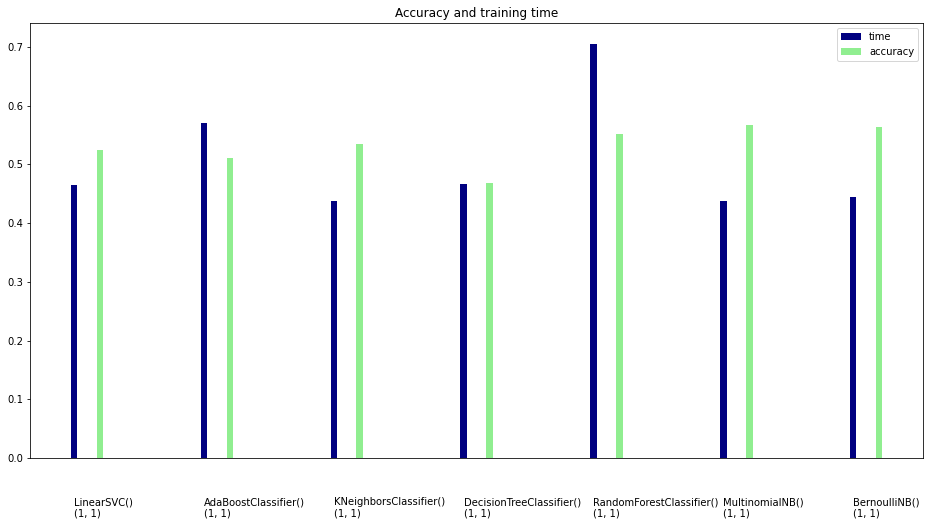

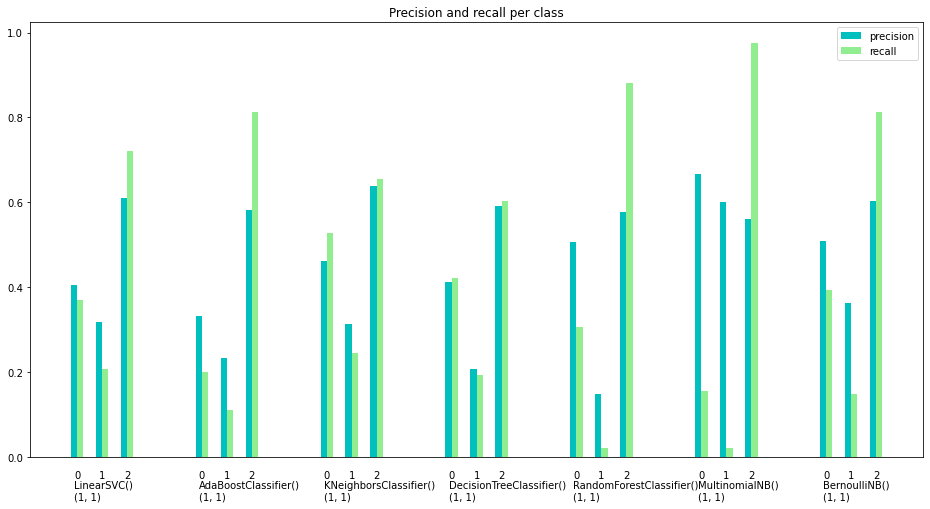

In [8]:
import pandas as pd

def makeHistogram(results):
    column_size = 0.05
    indices = np.arange(len(results))

    clf_names = [x["classifier"] for x in results]
    ngram = [x["ngram"] for x in results]
    scores = [x["scores"] for x in results]
    #print(scores)
    
    #plotting time and accuracy
    plt.figure(figsize=(16, 8))
    plt.title("Accuracy and training time")
    plt.bar(indices, [s["time"] for s in scores], column_size, label="time", color='navy')
    plt.bar(indices + .2, [s["accuracy"] for s in scores], column_size, label="accuracy", color='lightgreen')
    plt.xticks(())
    plt.legend(loc='best')
    
    for i, c in zip(indices, clf_names):
        plt.text(i, -.1, str(c) + "\n" + str(ngram[i]))

    plt.show()
    
    #plotting precision and recall scores for each class
    plt.figure(figsize=(16, 8))
    plt.title("Precision and recall per class")
    
    plt.bar(indices, [s["0"]["precision"] for s in scores], column_size, label="precision", color='c')
    plt.bar(indices + .2, [s["1"]["precision"] for s in scores], column_size, color='c')
    plt.bar(indices +.4, [s["2"]["precision"] for s in scores], column_size, color='c')
    
    plt.bar(indices + .05, [s["0"]["recall"] for s in scores], column_size, label="recall", color='lightgreen')
    plt.bar(indices + .25, [s["1"]["recall"] for s in scores], column_size, color='lightgreen')
    plt.bar(indices + .45, [s["2"]["recall"] for s in scores], column_size, color='lightgreen')
    
    plt.xticks(())
    plt.legend(loc='best')
    
    for i, c in zip(indices, clf_names):
        plt.text(i, -.1, str(c) + "\n" + str(ngram[i]))
        
    for i in indices:
        plt.text(i, -.05, "0")
        plt.text(i + .2, -.05, "1")
        plt.text(i + .4, -.05, "2")

    plt.show()
    
makeHistogram(results)

In [ ]:
# code for custom stop words
stop_words = [x.strip() for x in open('stopWords.txt','r').read().split('\n')]

folds = 10
print('NAIVE BAYES CLASSIFIER - CUSTOM STOP WORDS')
for i in range(max_ngram):
    for j in range(max_ngram):
        if j>= i :
            text_clf = Pipeline([
                ('vect', StemmedCountVectorizer(min_df=2, analyzer="word", strip_accents = "unicode", stop_words = stop_words, ngram_range = (i+1,j+1))),
                ('tfidf', TfidfTransformer(smooth_idf=True,use_idf=True)),
                ('clf', MultinomialNB()),
            ])
            scores = cross_validate(text_clf, dataset.tweet, dataset.label, cv=folds, scoring = scoring)
            print(f"------- ngram = {(i+1,j+1)} -------")
            print_metrics(scores)